In [ ]:
#!pip install tensorflow==2.7.0 tensorflow-gpu tensorflow_io==0.23.1 matplotlib

In [66]:
import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os, csv
import IPython as IPD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from itertools import groupby

In [32]:
#Data Folder. The original dataset is taken from Kaggle: https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing?resource=download
ROOT = "data"
capuchin_data = os.path.join(ROOT, "Parsed_Capuchinbird_Clips")
other_data = os.path.join(ROOT, "Parsed_Not_Capuchinbird_Clips")
forest_data = os.path.join(ROOT, "Forest_Recordings")

DOWNSAMPLE_RATE = 16000
EPOCHS = 10
EXAMPLE_FILE_CAPUCHIN = os.path.join(capuchin_data, "XC16803-1.wav")
EXAMPLE_FILE_NOT_CAPUCHIN = os.path.join(other_data, "afternoon-birds-song-in-forest-2.wav")


In [90]:
#Downsampling data from 44.1khz to xxx khz
def downsample_audio(filename, downsampling_rate, is_forest=False):
  file, to_tensor, sample_rate, wav = "","", "",""
  if is_forest:
    file = tfio.audio.AudioIOTensor(filename)
    to_tensor = file.to_tensor()
    to_tensor = tf.math.reduce_sum(to_tensor, axis=1) /2
    sample_rate = tf.cast(file.rate, dtype=tf.int64)
    wav = tfio.audio.resample(to_tensor, rate_in=sample_rate, rate_out=downsampling_rate)
  else:
    file = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=downsampling_rate)
  
  return wav

# Playing some data

##How Capuchin Bird sounds like

In [22]:
IPD.display.Audio(EXAMPLE_FILE_CAPUCHIN)

## Other Sounds

In [23]:
IPD.display.Audio(EXAMPLE_FILE_NOT_CAPUCHIN)

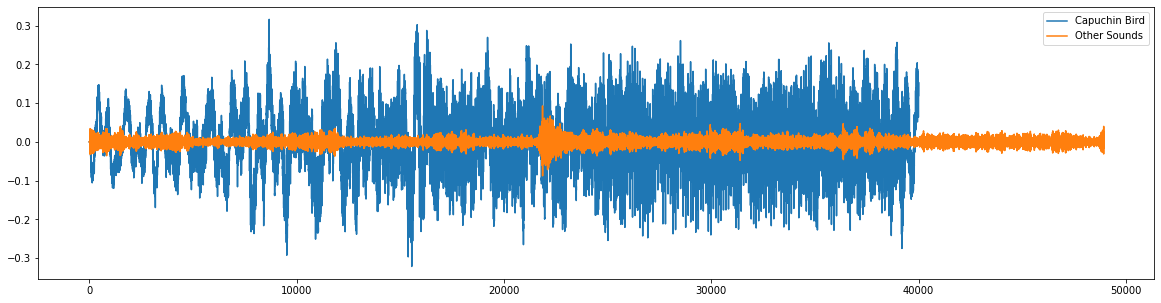

In [33]:
#Downsample and plot
plt.figure(figsize=(20,5))
plt.plot(downsample_audio(EXAMPLE_FILE_CAPUCHIN, DOWNSAMPLE_RATE))
plt.plot(downsample_audio(EXAMPLE_FILE_NOT_CAPUCHIN, DOWNSAMPLE_RATE))
plt.legend(['Capuchin Bird', 'Other Sounds'])
plt.show()

### Stats on the capuchin bird data


In [34]:
lengths = []

for file in os.listdir(capuchin_data):
  downsampled_audio = downsample_audio(os.path.join(capuchin_data, file), DOWNSAMPLE_RATE)
  lengths.append(len(downsampled_audio))


In [35]:
print(f"Longest call of the capuchin bird is {max(lengths)/DOWNSAMPLE_RATE} seconds")
print(f"Shortest call of the capuchin bird is {min(lengths)/DOWNSAMPLE_RATE} seconds")
print(f"Average call of the capuchin bird is {round(sum(lengths)/len(lengths))/DOWNSAMPLE_RATE} seconds")

Longest call of the capuchin bird is 5.0 seconds
Shortest call of the capuchin bird is 2.0 seconds
Average call of the capuchin bird is 3.3848125 seconds


We can take the average as ballpark which is ~54000


In [36]:
selected_length = int(round(sum(lengths)/len(lengths),-3))
selected_length

54000

In [37]:
#Loading all data
pos = tf.data.Dataset.list_files(capuchin_data+'/*.wav')
neg = tf.data.Dataset.list_files(other_data+'/*.wav')

pos_dataset = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
neg_dataset = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
full_data = pos_dataset.concatenate(neg_dataset)

In [38]:
def preprocess_data(file_path, label):
  file_audio = downsample_audio(file_path, DOWNSAMPLE_RATE)
  file_audio = file_audio[:selected_length]
  zero_padding = tf.zeros([selected_length] - tf.shape(file_audio), dtype=tf.float32)
  file_audio = tf.concat([zero_padding, file_audio], 0)
  spectrogram = tf.abs(tf.signal.stft(file_audio, frame_length=320, frame_step=32))
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [39]:
def preprocess_data_full_audio(sample, label):
  file_audio = sample[0]
  zero_padding = tf.zeros([selected_length] - tf.shape(file_audio), dtype=tf.float32)
  file_audio = tf.concat([zero_padding, file_audio], 0)
  spectrogram = tf.abs(tf.signal.stft(file_audio, frame_length=320, frame_step=32))
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [41]:
import numpy as np
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

# Plotting Spectrogram Example - CAPUCHIN



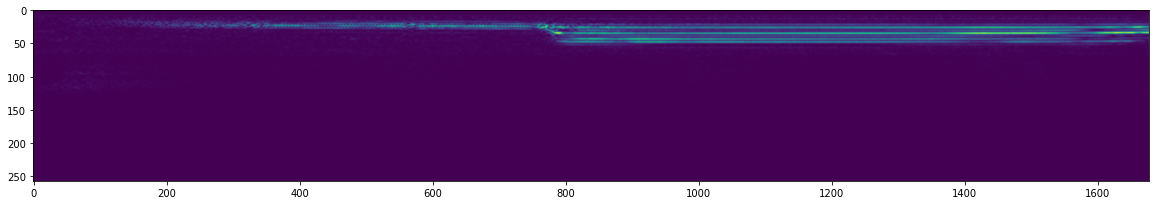

In [40]:
filepath, label = pos_dataset.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram , label = preprocess_data(filepath, label)
plt.figure(figsize=(20,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Plotting Spectrogram Example - OTHER

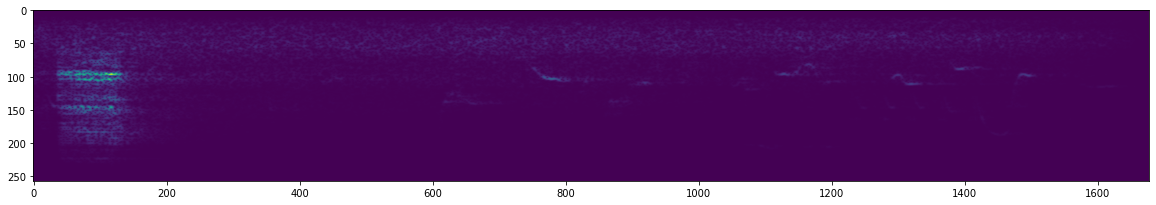

In [46]:
filepath, label = neg_dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram , label = preprocess_data(filepath, label)
plt.figure(figsize=(20,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [52]:
#Data Pipeline
full_data_pipeline = full_data.map(preprocess_data).cache().shuffle(buffer_size=1000).batch(16).prefetch(8)

In [55]:
total = int(len(full_data_pipeline))
train_data = full_data_pipeline.take(int(total*0.7))
val_data = full_data_pipeline.skip(int(total*0.7)).take(int(total*0.1))
test_data = full_data_pipeline.skip(int(total*0.7)).skip(int(total*0.1)).take(int(total*0.2))

In [63]:
print('Training batch size', len(train_data))
print('Validation batch size', len(val_data))
print('Test batch size', len(test_data))


Training batch size 35
Validation batch size 5
Test batch size 10


In [54]:
samples, labels = train_data.as_numpy_iterator().next()
samples.shape

(16, 1678, 257, 1)

In [ ]:
labels

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

#BUILDING THE MODEL

In [67]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1678, 257, 1)))
model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [68]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1676, 255, 16)     160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 838, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 836, 126, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 418, 63, 16)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 421344)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [69]:
hist = model.fit(train_data, epochs=10, validation_data=test_data, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=5,
                                               restore_best_weights=True
                                              ),)

Epoch 1/10
35/35 [==============================] - 58s 2s/step - loss: 2.5330 - recall_1: 0.8714 - precision_1: 0.7871 - val_loss: 0.2347 - val_recall_1: 0.8980 - val_precision_1: 0.9362
Epoch 2/10
35/35 [==============================] - 59s 2s/step - loss: 0.2148 - recall_1: 0.9128 - precision_1: 0.9444 - val_loss: 0.0367 - val_recall_1: 0.9545 - val_precision_1: 1.0000
Epoch 3/10
35/35 [==============================] - 58s 2s/step - loss: 0.0384 - recall_1: 0.9799 - precision_1: 0.9865 - val_loss: 0.0104 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/10
35/35 [==============================] - 58s 2s/step - loss: 0.0114 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0075 - val_recall_1: 0.9756 - val_precision_1: 1.0000
Epoch 5/10
35/35 [==============================] - 61s 2s/step - loss: 0.0034 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 0.0018 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 6/10
35/35 [==============================] - 58s 2s/s

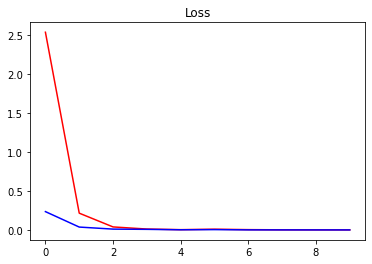

In [70]:
plt.title("Loss")
plt.plot(hist.history["loss"], "r")
plt.plot(hist.history["val_loss"], "b")
plt.show()

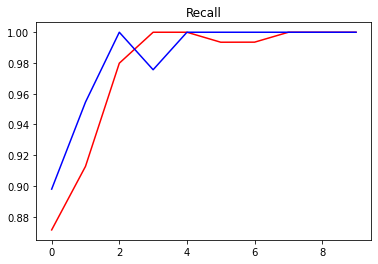

In [73]:
plt.title("Recall")
plt.plot(hist.history["recall_1"], "r")
plt.plot(hist.history["val_recall_1"], "b")
plt.show()

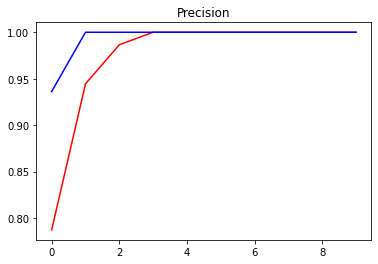

In [74]:
plt.title("Precision")
plt.plot(hist.history["precision_1"], "r")
plt.plot(hist.history["val_precision_1"], "b")
plt.show()

In [82]:
test_audio = []
test_labels = []
cnt = 0

for X_test, y_test in test_data.as_numpy_iterator():

    y_hat = model.predict(X_test)
    y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]
    print(f'Predicted labels: {y_hat}')
    print(f'True labels: {y_test}')
    for idx, item in enumerate(y_hat):
        if item == y_test[idx]:
            cnt+=1
    print(f'Accuracy is {(cnt/16)*100} %')
    cnt = 0

1/1 [==============================] - 23s 23s/step
Predicted labels: [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
True labels: [0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Accuracy is 100.0
1/1 [==============================] - 23s 23s/step
Predicted labels: [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
True labels: [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
Accuracy is 100.0
1/1 [==============================] - 21s 21s/step
Predicted labels: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Accuracy is 100.0
1/1 [==============================] - 22s 22s/step
Predicted labels: [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
True labels: [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
Accuracy is 100.0
1/1 [==============================] - 21s 21s/step
Predicted labels: [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
True labels: [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Accuracy is 100.0


### Working with full audio

In [84]:
detections = {}

for file in os.listdir(forest_data):
  file_path = os.path.join(forest_data, file)

  wav = downsample_audio(file_path, DOWNSAMPLE_RATE, is_forest=True)
  #Splitting into subsequences
  wav_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=selected_length, sequence_stride=selected_length, batch_size=1)
  wav_slices = wav_slices.map(preprocess_data_full_audio)
  wav_slices = wav_slices.batch(32)

  yhat = model.predict(wav_slices)
  detections[file] = yhat


2/2 [==============================] - 43s 409ms/step


In [85]:
final_preds= {}
for file, logits in detections.items():
  final_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

combined_preds = {}
for file, converted_logits in final_preds.items():
  combined_preds[file] = tf.math.reduce_sum([key for key, group in groupby(converted_logits)]).numpy()

combined_preds

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 6,
 'recording_05.mp3': 0,
 'recording_06.mp3': 7,
 'recording_07.mp3': 2,
 'recording_08.mp3': 12,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 10,
 'recording_18.mp3': 5,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 1,
 'recording_29.mp3': 2,
 'recording_30.mp3': 2,
 'recording_31.mp3': 2,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 9,
 'recording_39.mp3': 1,
 'recording_40.mp3': 2,
 'recording_41

In [86]:
max_count = max([value for value in combined_preds.values()])
print(f'Max count in a single forest file is {max_count}')

Max count in a single forest file is 14


In [87]:
file_names = []
sep = ','
for k, v in combined_preds.items():
    if v == max_count:
        file_names.append(k)
print(f'Files with max count are {sep.join(file_names)}')

Files with max count are recording_98.mp3


# Visualize Predictions

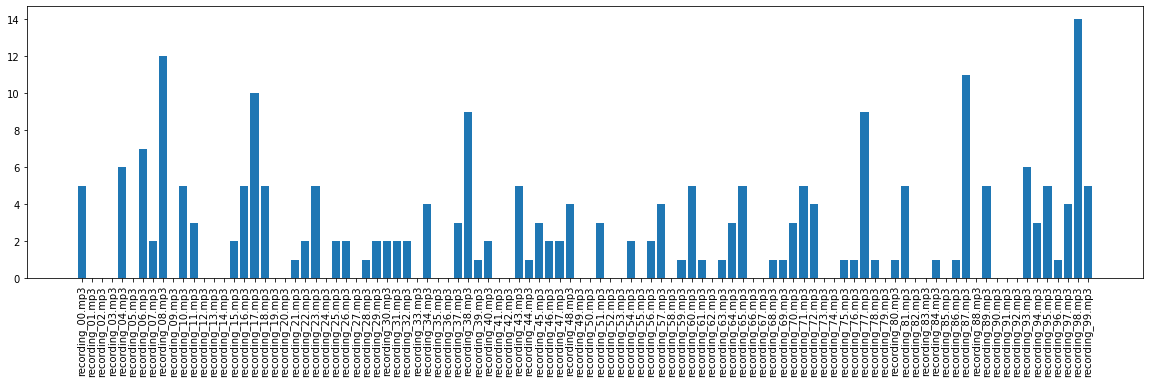

In [88]:
names = list(combined_preds.keys())
values = list(combined_preds.values())
plt.figure(figsize=(20,5))
plt.xticks(rotation='vertical')
plt.bar(range(len(combined_preds)), values, tick_label=names)
plt.show()

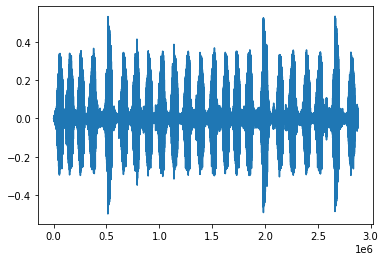

<Figure size 2160x720 with 0 Axes>

In [92]:
plt.plot(downsample_audio(os.path.join(forest_data, "recording_98.mp3"), DOWNSAMPLE_RATE, is_forest=True))
plt.figure(figsize=(30,10))
plt.show()

In [93]:
IPD.display.Audio(os.path.join(forest_data, "recording_98.mp3"))


It seems that there more than just 14 calls in file recording_98. Let's check some random audio where no detection was observed.

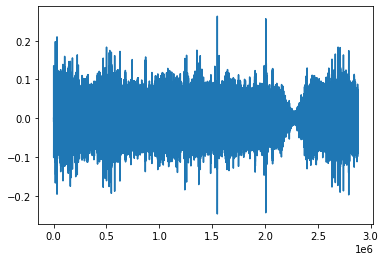

<Figure size 2160x720 with 0 Axes>

In [95]:
plt.plot(downsample_audio(os.path.join(forest_data, "recording_01.mp3"), DOWNSAMPLE_RATE, is_forest=True))
plt.figure(figsize=(30,10))
plt.show()

In [97]:
IPD.display.Audio(os.path.join(forest_data, "recording_01.mp3"))


Let's check if a random file has the right detected # of calls

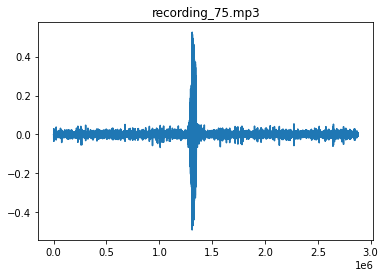

<Figure size 2160x720 with 0 Axes>

In [115]:
import random
n = str(random.randint(1,len(detections))).zfill(2)
plt.plot(downsample_audio(os.path.join(forest_data, "recording_"+n+".mp3"), DOWNSAMPLE_RATE, is_forest=True))
plt.title("recording_"+n+".mp3")
plt.figure(figsize=(30,10))
plt.show()



In [116]:
calls = combined_preds["recording_"+n+".mp3"]
print(f"Number of calls identified {calls}")

Number of calls identified 1


In [118]:
#Another file

calls = combined_preds["recording_00.mp3"]
print(f"Number of calls identified {calls}")

Number of calls identified 5


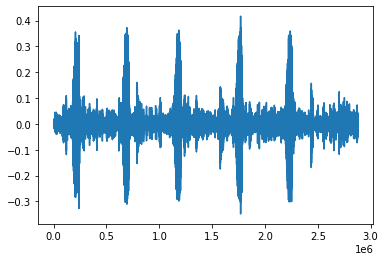

<Figure size 2160x720 with 0 Axes>

In [117]:
plt.plot(downsample_audio(os.path.join(forest_data, "recording_00.mp3"), DOWNSAMPLE_RATE, is_forest=True))
plt.figure(figsize=(30,10))
plt.show()

This is correct as well. 

In [123]:
sorted_dict = {k: v for k, v in reversed(sorted(combined_preds.items(), key=lambda item: item[1]))}
sorted_dict

{'recording_98.mp3': 14,
 'recording_08.mp3': 12,
 'recording_87.mp3': 11,
 'recording_17.mp3': 10,
 'recording_77.mp3': 9,
 'recording_38.mp3': 9,
 'recording_06.mp3': 7,
 'recording_93.mp3': 6,
 'recording_04.mp3': 6,
 'recording_99.mp3': 5,
 'recording_95.mp3': 5,
 'recording_89.mp3': 5,
 'recording_81.mp3': 5,
 'recording_71.mp3': 5,
 'recording_65.mp3': 5,
 'recording_60.mp3': 5,
 'recording_43.mp3': 5,
 'recording_23.mp3': 5,
 'recording_18.mp3': 5,
 'recording_16.mp3': 5,
 'recording_10.mp3': 5,
 'recording_00.mp3': 5,
 'recording_97.mp3': 4,
 'recording_72.mp3': 4,
 'recording_57.mp3': 4,
 'recording_48.mp3': 4,
 'recording_34.mp3': 4,
 'recording_94.mp3': 3,
 'recording_70.mp3': 3,
 'recording_64.mp3': 3,
 'recording_51.mp3': 3,
 'recording_45.mp3': 3,
 'recording_37.mp3': 3,
 'recording_11.mp3': 3,
 'recording_56.mp3': 2,
 'recording_54.mp3': 2,
 'recording_47.mp3': 2,
 'recording_46.mp3': 2,
 'recording_40.mp3': 2,
 'recording_32.mp3': 2,
 'recording_31.mp3': 2,
 'recording_

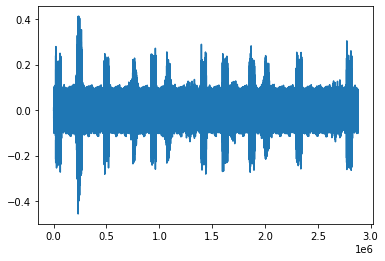

<Figure size 2160x720 with 0 Axes>

In [134]:

plt.plot(downsample_audio(os.path.join(forest_data, "recording_89.mp3"), DOWNSAMPLE_RATE, is_forest=True))
plt.figure(figsize=(30,10))
plt.show()

File 89 was identified correctly although based on the waveform looks like there would be more calls than just 5. Some calls are very low but still identified by the model.
For audios with high density calls the model does not perform perfectly. Probably having more balanced data and/or changing a bit the model architecture could help identify better. Maybe even having a different window would be beneficial, above was used 54000. 

In [ ]:
with open("results.csv", "w", newline="") as file:
  writer = csv.writer(file, delimiter=",")
  writer.writerow(["filename", "# capuchin calls"])
  for key, value in combined_preds.items():
    writer.writerow([key, value])